# 1. Setup

In [24]:
# Import Library
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'

from tqdm import tqdm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# === BASE PATH SETUP ===
BASE_DIR = r".."
DATASET_DIR = os.path.join(BASE_DIR, "Dataset")
OUTPUT_DIR  = os.path.join(BASE_DIR, "Output_Data")
FEATURE_DIR = os.path.join(BASE_DIR, "Features")
MODEL_DIR   = os.path.join(BASE_DIR, "Models")

# create dirs if not exist
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(FEATURE_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

ALL_DATA_CSV = os.path.join(BASE_DIR, "all_data.csv")
FEATURES_CSV = os.path.join(FEATURE_DIR, "features_df.csv")
MODEL_FILE   = os.path.join(MODEL_DIR, "rf_model.pkl")

ACTIVITIES = [
    "Laying_Foot","Laying_Hand","Sitting_Foot","Sitting_Hand",
    "Standing_Foot","Standing_Hand","Walking_Foot","Walking_Hand",
    "Walking_Downstairs_Foot","Walking_Downstairs_Hand",
    "Walking_Upstairs_Foot","Walking_Upstairs_Hand"
]

WINDOW_SIZE = 200      # 2 detik @100Hz
STEP_SIZE   = 100      # overlap 50%

print("📁 Ready — All paths set.")

📁 Ready — All paths set.


# 2. Load Data per Activity

In [26]:
# ========== Cell 2: Load per-activity CSV from Output_Data ==========

print("📥 Loading dataset per activity...")
data_dict = {}
for act in ACTIVITIES:
    fp = os.path.join(OUTPUT_DIR, f"{act}.csv")
    if os.path.exists(fp):
        data_dict[act] = pd.read_csv(fp)
        print(f"  ✓ Loaded: {act} ({len(data_dict[act])} rows)")
    else:
        print(f"  ⚠️ Missing: {act}")

print("\n✅ Data loading complete.")

📥 Loading dataset per activity...
  ✓ Loaded: Laying_Foot (470245 rows)
  ✓ Loaded: Laying_Hand (476149 rows)
  ✓ Loaded: Sitting_Foot (477158 rows)
  ✓ Loaded: Sitting_Hand (474980 rows)
  ✓ Loaded: Standing_Foot (469283 rows)
  ✓ Loaded: Standing_Hand (468550 rows)
  ✓ Loaded: Walking_Foot (481179 rows)
  ✓ Loaded: Walking_Hand (476898 rows)
  ✓ Loaded: Walking_Downstairs_Foot (475798 rows)
  ✓ Loaded: Walking_Downstairs_Hand (474301 rows)
  ✓ Loaded: Walking_Upstairs_Foot (471673 rows)
  ✓ Loaded: Walking_Upstairs_Hand (494394 rows)

✅ Data loading complete.


# 3. Visualisasi Jumlah Data per Aktivitas

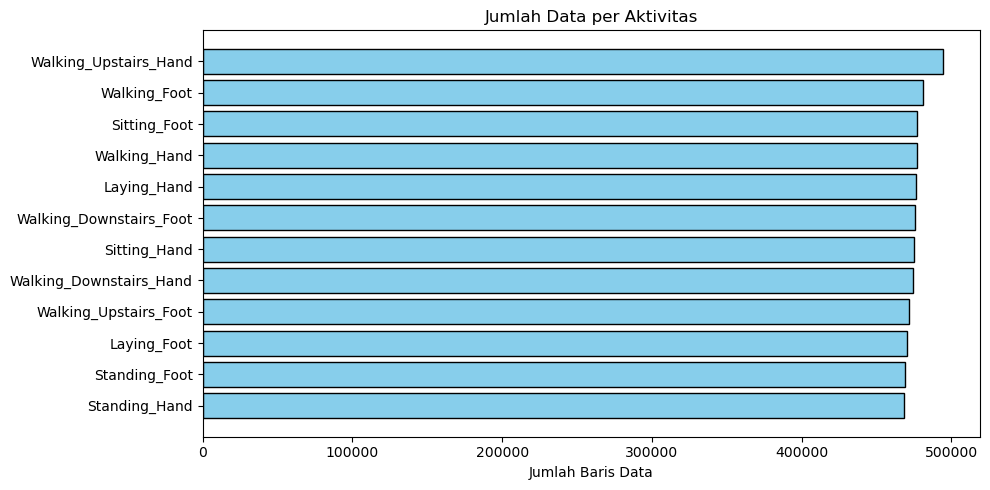

Standing_Hand              468550
Standing_Foot              469283
Laying_Foot                470245
Walking_Upstairs_Foot      471673
Walking_Downstairs_Hand    474301
Sitting_Hand               474980
Walking_Downstairs_Foot    475798
Laying_Hand                476149
Walking_Hand               476898
Sitting_Foot               477158
Walking_Foot               481179
Walking_Upstairs_Hand      494394
dtype: int64

In [28]:
# ========== Cell 3: Bar chart jumlah data per activity ==========

counts = {act: len(data_dict[act]) for act in data_dict.keys()}
s = pd.Series(counts).sort_values(ascending=True)

plt.figure(figsize=(10, 5))
plt.barh(s.index, s.values, color="skyblue", edgecolor="black")
plt.title("Jumlah Data per Aktivitas")
plt.xlabel("Jumlah Baris Data")
plt.tight_layout()
plt.show()

s

# 4. Ekstraksi Fitur per Window

In [30]:
# ========== Cell 4: Ekstraksi fitur ke Features/features_df.csv ==========

def extract_features_from_window(window_df):
    feats = {}
    cols = ["Accel_X","Accel_Y","Accel_Z","Gyro_X","Gyro_Y","Gyro_Z","Mag_X","Mag_Y","Mag_Z"]
    for col in cols:
        vals = window_df[col].values
        feats[f"{col}_mean"] = np.mean(vals)
        feats[f"{col}_std"] = np.std(vals)
        feats[f"{col}_max"] = np.max(vals)
        feats[f"{col}_min"] = np.min(vals)
        feats[f"{col}_range"] = np.max(vals) - np.min(vals)
        feats[f"{col}_energy"] = np.sum(vals**2) / len(vals)
    return feats

if not os.path.exists(FEATURES_CSV):
    print("🚀 Ekstraksi fitur dimulai...")
    all_features = []
    for act, df in data_dict.items():
        for i in tqdm(range(0, len(df) - WINDOW_SIZE, STEP_SIZE), desc=f"{act}"):
            window = df.iloc[i:i+WINDOW_SIZE]
            f = extract_features_from_window(window)
            f["Activity"] = act
            all_features.append(f)
    features_df = pd.DataFrame(all_features)
    features_df.to_csv(FEATURES_CSV, index=False)
    print(f"✅ fitur disimpan ke: {FEATURES_CSV}  | Total rows: {len(features_df)}")

else:
    print("📂 fitur sudah ada — loading...")
    features_df = pd.read_csv(FEATURES_CSV)

features_df.head()

📂 fitur sudah ada — loading...


,Accel_X_mean,Accel_X_std,Accel_X_max,Accel_X_min,Accel_X_range,Accel_X_energy,Accel_Y_mean,Accel_Y_std,Accel_Y_max,Accel_Y_min,...,Mag_Y_min,Mag_Y_range,Mag_Y_energy,Mag_Z_mean,Mag_Z_std,Mag_Z_max,Mag_Z_min,Mag_Z_range,Mag_Z_energy,Activity
0,0.308507,0.019130,0.366102,0.275175,0.090927,0.095542,-0.663159,0.010142,-0.638884,-0.686740,...,-9.806251,1.031250,84.764300,9.456750,0.206548,9.787500,9.000000,0.7875,89.472791,Laying_Foot
1,0.311916,0.014661,0.337388,0.275175,0.062213,0.097507,-0.663948,0.009678,-0.646062,-0.686740,...,-9.300000,0.974999,76.833323,9.699375,0.178952,9.993751,9.431251,0.5625,94.109908,Laying_Foot
2,0.312359,0.012329,0.337388,0.282353,0.055035,0.097720,-0.663207,0.010949,-0.638884,-0.686740,...,-8.812500,0.674999,71.769221,9.894750,0.089690,10.068750,9.768750,0.3000,97.914131,Laying_Foot
3,0.310098,0.013297,0.342174,0.287139,0.055035,0.096337,-0.666186,0.012745,-0.638884,-0.696311,...,-9.168751,1.031250,76.713638,10.172250,0.292025,10.725000,9.862500,0.8625,103.559956,Laying_Foot
4,0.311258,0.014199,0.342174,0.287139,0.055035,0.097083,-0.672790,0.011541,-0.643669,-0.696311,...,-9.168751,0.600000,78.764742,10.023000,0.488453,10.725000,9.150001,1.5750,100.699122,Laying_Foot


# 5. Training Random Forest

In [32]:
# ========== Cell 5: Train Random Forest Classifier ==========

X = features_df.drop(columns=["Activity"])
y = features_df["Activity"]

# encode label
le = LabelEncoder()
y_enc = le.fit_transform(y)

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    class_weight="balanced_subsample",
    random_state=42,
    n_jobs=-1
)

print("🚀 Training model...")
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Save model
joblib.dump(rf, MODEL_FILE)
print(f"\n✅ Model disimpan ke: {MODEL_FILE}")

🚀 Training model...

=== Classification Report ===
                         precision    recall  f1-score   support

            Laying_Foot       1.00      1.00      1.00       940
            Laying_Hand       1.00      0.96      0.98       952
           Sitting_Foot       1.00      0.99      1.00       954
           Sitting_Hand       0.97      0.98      0.97       950
          Standing_Foot       1.00      0.99      1.00       938
          Standing_Hand       0.98      0.92      0.95       937
Walking_Downstairs_Foot       0.88      0.92      0.90       951
Walking_Downstairs_Hand       0.84      0.92      0.88       948
           Walking_Foot       0.89      0.89      0.89       962
           Walking_Hand       0.90      0.95      0.93       954
  Walking_Upstairs_Foot       0.91      0.88      0.89       943
  Walking_Upstairs_Hand       0.90      0.84      0.87       989

               accuracy                           0.94     11418
              macro avg       0.94   

# 6. Confusion Matrix

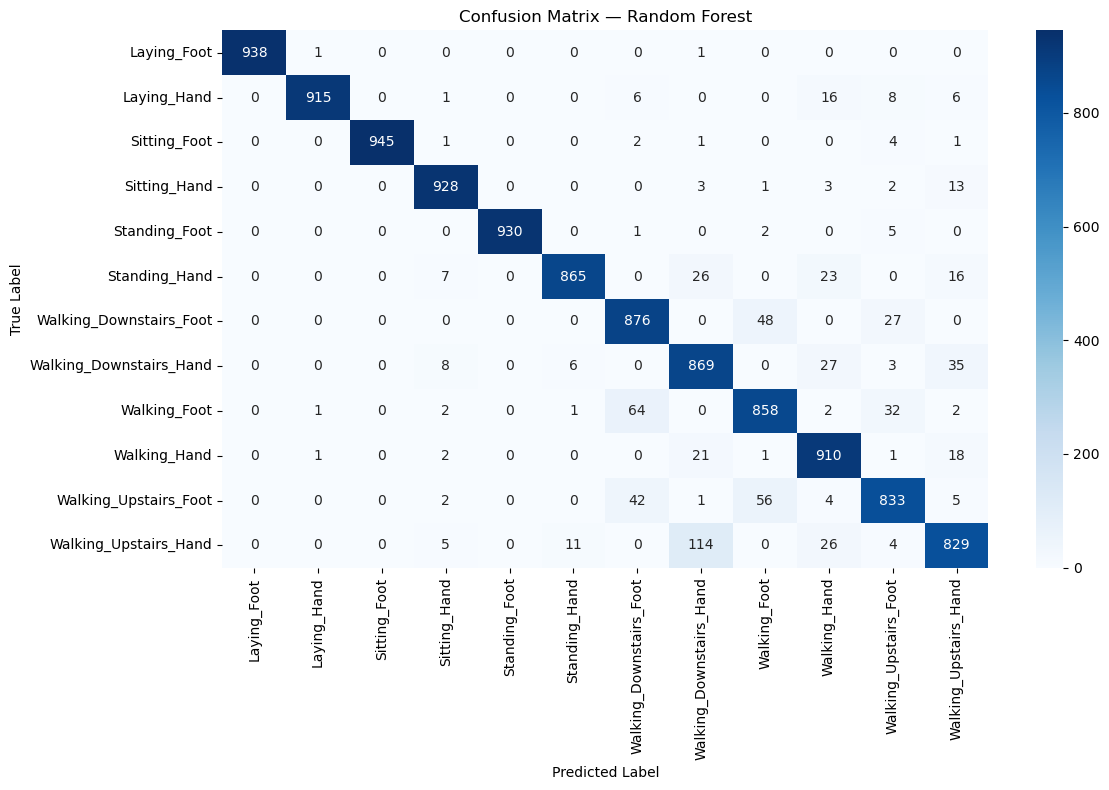

In [34]:
# ========== Cell 6: Confusion Matrix ==========

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix — Random Forest")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

# 7. Feature Importance

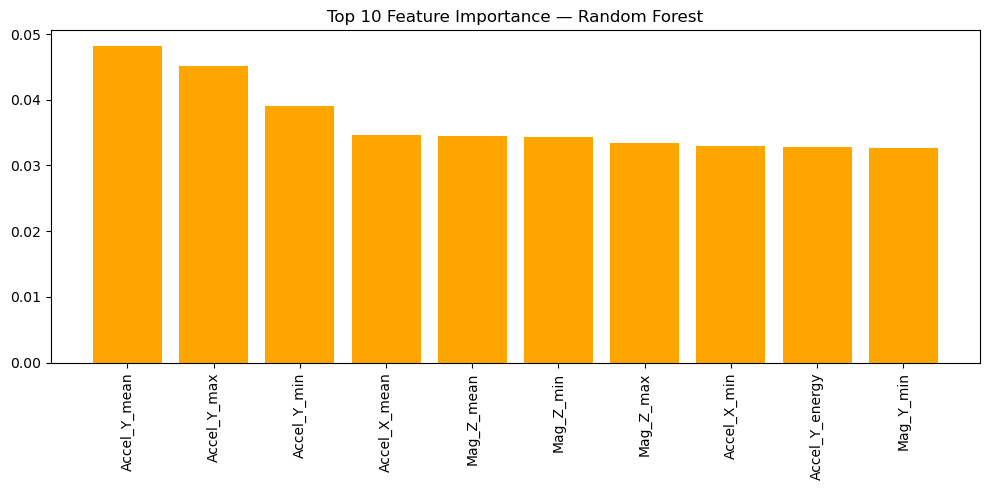

In [36]:
# ========== Cell 7: Feature Importance ==========

importances = rf.feature_importances_
idx = np.argsort(importances)[::-1][:10]

plt.figure(figsize=(10,5))
plt.bar(range(len(idx)), importances[idx], color="orange")
plt.xticks(range(len(idx)), X.columns[idx], rotation=90)
plt.title("Top 10 Feature Importance — Random Forest")
plt.tight_layout()
plt.show()

# 8. Demo Prediksi 1 Window

In [38]:
# ========== Cell 8: Demo Prediksi Window ==========

def demo_predict_window(activity, data_dict=data_dict, model=rf):
    df = data_dict[activity]
    window = df.iloc[0:WINDOW_SIZE]
    feat = extract_features_from_window(window)
    feat_arr = np.array(list(feat.values())).reshape(1, -1)
    pred = model.predict(feat_arr)[0]
    pred_label = le.inverse_transform([pred])[0]
    
    print(f"\n🟢 Demo prediksi 1 window:")
    print(f"   Actual Activity  : {activity}")
    print(f"   Predicted Result : {pred_label}")
    print(f"   Match? {'✅' if pred_label == activity else '❌'}")

# Test demo untuk 3 aktivitas:
demo_predict_window("Walking_Hand")
demo_predict_window("Standing_Foot")
demo_predict_window("Laying_Foot")


🟢 Demo prediksi 1 window:
   Actual Activity  : Walking_Hand
   Predicted Result : Sitting_Hand
   Match? ❌

🟢 Demo prediksi 1 window:
   Actual Activity  : Standing_Foot
   Predicted Result : Standing_Foot
   Match? ✅

🟢 Demo prediksi 1 window:
   Actual Activity  : Laying_Foot
   Predicted Result : Laying_Foot
   Match? ✅


# Model ML (Random Forest)

Data gabungan baru berhasil dibuat!
Jumlah baris: 19285


,Time (s),Accel_X,Accel_Y,Accel_Z,Gyro_X,Gyro_Y,Gyro_Z,Mag_X,Mag_Y,Mag_Z
0,0.08,-3.905087,2.093720,7.833503,-1.701492,-0.932505,-0.448210,17.1898,-7.3688,34.513798
1,0.08,-3.905087,2.093720,7.833503,-1.714142,-0.919722,-0.478037,17.1898,-7.3688,34.513798
2,0.08,-3.905087,2.093720,7.833503,-1.735448,-0.904808,-0.508930,17.1898,-7.3688,34.513798
3,0.08,-3.905087,2.093720,7.833503,-1.762079,-0.879242,-0.532366,17.1898,-7.3688,34.513798
4,0.08,-3.862016,1.988436,7.919645,-1.701492,-0.932505,-0.448210,17.1898,-7.3688,34.513798


Jumlah window yang diekstraksi: 191
Model berhasil dimuat!

=== HASIL PREDIKSI UTAMA ===
Aktivitas terdeteksi: 7


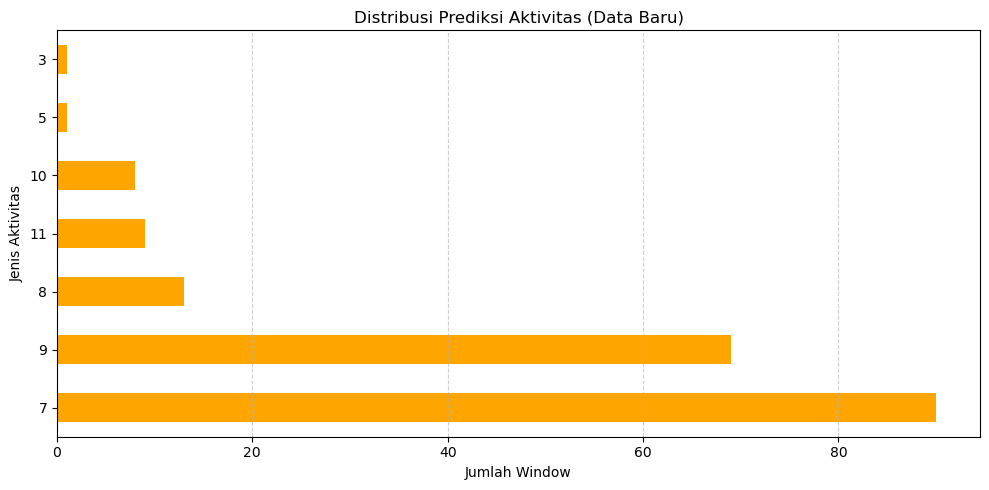

In [40]:
# =========================================================
# 1️⃣ Import library
# =========================================================
import pandas as pd
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt

# =========================================================
# 2️⃣ Path model dan data baru
# =========================================================
MODEL_PATH = r"C:\Users\Zain Iqbal Saputra\Pemrograman Sains Data 2\Time Series\Models\rf_model.pkl"
NEW_FOLDER = r"C:\Users\Zain Iqbal Saputra\Pemrograman Sains Data 2\Time Series\New_Data\New"

# Pastikan semua file sensor ada
accel_file = os.path.join(NEW_FOLDER, "Accelerometer.csv")
gyro_file = os.path.join(NEW_FOLDER, "Gyroscope.csv")
mag_file = os.path.join(NEW_FOLDER, "Magnetometer.csv")

if not (os.path.exists(accel_file) and os.path.exists(gyro_file) and os.path.exists(mag_file)):
    raise FileNotFoundError("Pastikan ada file Accelerometer.csv, Gyroscope.csv, dan Magnetometer.csv di folder 'New'!")

# =========================================================
# 3️⃣ Gabungkan ketiga sensor jadi satu dataframe
# =========================================================
accel = pd.read_csv(accel_file)
gyro = pd.read_csv(gyro_file)
mag = pd.read_csv(mag_file)

# Samakan kolom waktu
accel["Time (s)"] = accel["Time (s)"].round(2)
gyro["Time (s)"] = gyro["Time (s)"].round(2)
mag["Time (s)"] = mag["Time (s)"].round(2)

# Ganti nama kolom
accel.columns = ["Time (s)", "Accel_X", "Accel_Y", "Accel_Z"]
gyro.columns = ["Time (s)", "Gyro_X", "Gyro_Y", "Gyro_Z"]
mag.columns = ["Time (s)", "Mag_X", "Mag_Y", "Mag_Z"]

# Gabungkan berdasarkan waktu
new_data = accel.merge(gyro, on="Time (s)", how="inner").merge(mag, on="Time (s)", how="inner")

print("Data gabungan baru berhasil dibuat!")
print("Jumlah baris:", len(new_data))
display(new_data.head())

# =========================================================
# 4️⃣ Fungsi ekstraksi fitur (sama dengan model)
# =========================================================
def extract_features_from_window(window_df):
    features = {}
    for col in ["Accel_X", "Accel_Y", "Accel_Z",
                "Gyro_X", "Gyro_Y", "Gyro_Z",
                "Mag_X", "Mag_Y", "Mag_Z"]:
        data = window_df[col].values
        features[f"{col}_mean"] = np.mean(data)
        features[f"{col}_std"] = np.std(data)
        features[f"{col}_max"] = np.max(data)
        features[f"{col}_min"] = np.min(data)
        features[f"{col}_range"] = np.max(data) - np.min(data)
        features[f"{col}_energy"] = np.sum(data ** 2) / len(data)
    return features

# =========================================================
# 5️⃣ Windowing dan ekstraksi fitur
# =========================================================
WINDOW_SIZE = 200
STEP_SIZE = 100

windows = []
for i in range(0, len(new_data) - WINDOW_SIZE, STEP_SIZE):
    window = new_data.iloc[i:i+WINDOW_SIZE]
    feat = extract_features_from_window(window)
    windows.append(feat)

features_df = pd.DataFrame(windows)
print("Jumlah window yang diekstraksi:", len(features_df))

# =========================================================
# 6️⃣ Load model dan prediksi
# =========================================================
model = joblib.load(MODEL_PATH)
print("Model berhasil dimuat!")

predictions = model.predict(features_df)

# =========================================================
# 7️⃣ Ambil hasil akhir
# =========================================================
hasil_final = pd.Series(predictions).value_counts().idxmax()
print("\n=== HASIL PREDIKSI UTAMA ===")
print("Aktivitas terdeteksi:", hasil_final)
print("==============================")

# =========================================================
# 8️⃣ Visualisasi distribusi hasil prediksi
# =========================================================
plt.figure(figsize=(10,5))
pd.Series(predictions).value_counts().plot(kind="barh", color="orange")
plt.title("Distribusi Prediksi Aktivitas (Data Baru)")
plt.xlabel("Jumlah Window")
plt.ylabel("Jenis Aktivitas")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


=== HASIL PREDIKSI UTAMA ===
Aktivitas terdeteksi: Walking_Hand


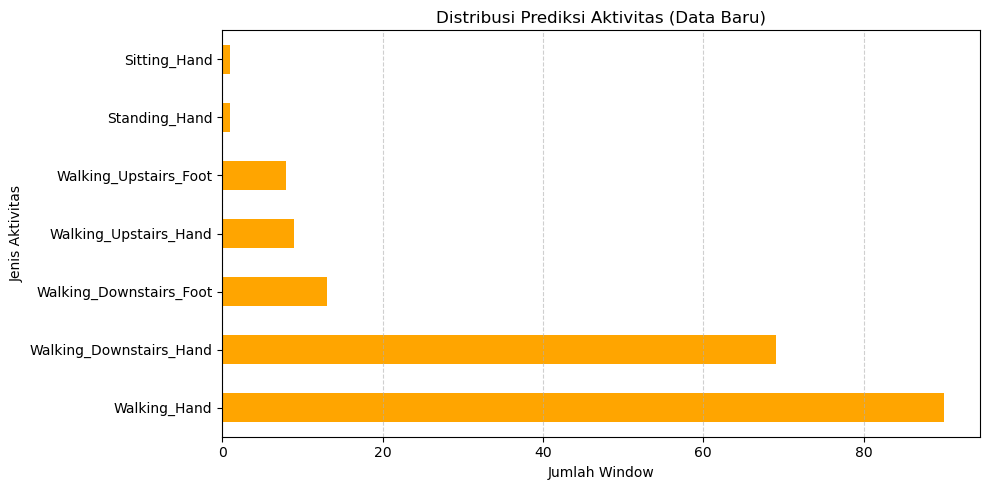

In [42]:
# Label Aktifitas
activity_labels = [
    "Laying_Foot","Laying_Hand","Sitting_Foot","Sitting_Hand",
    "Standing_Foot","Standing_Hand","Walking_Foot","Walking_Hand",
    "Walking_Downstairs_Foot","Walking_Downstairs_Hand",
    "Walking_Upstairs_Foot","Walking_Upstairs_Hand"
]

# Hasil Prediksi
decoded_predictions = [activity_labels[i] for i in predictions]

# Hasil Akhir
hasil_final = pd.Series(decoded_predictions).value_counts().idxmax()
print("\n=== HASIL PREDIKSI UTAMA ===")
print("Aktivitas terdeteksi:", hasil_final)
print("==============================")

# Visualisasi
plt.figure(figsize=(10,5))
pd.Series(decoded_predictions).value_counts().plot(kind="barh", color="orange")
plt.title("Distribusi Prediksi Aktivitas (Data Baru)")
plt.xlabel("Jumlah Window")
plt.ylabel("Jenis Aktivitas")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Percobaan

✅ Data baru berhasil digabung! Jumlah baris: 13968


,Time (s),Accel_X,Accel_Y,Accel_Z,Gyro_X,Gyro_Y,Gyro_Z,Mag_X,Mag_Y,Mag_Z
0,0.04,-2.35500,2.84595,9.252001,-0.496375,-0.570212,0.382387,13.668751,5.8875,39.993752
1,0.04,-2.35500,2.84595,9.252001,-0.461175,-0.544775,0.374963,13.668751,5.8875,39.993752
2,0.04,-2.35500,2.84595,9.252001,-0.426113,-0.514938,0.367537,13.668751,5.8875,39.993752
3,0.04,-2.35500,2.84595,9.252001,-0.389950,-0.488263,0.357913,13.668751,5.8875,39.993752
4,0.04,-2.37105,2.81295,9.286051,-0.496375,-0.570212,0.382387,13.668751,5.8875,39.993752


🔍 Total window diekstraksi: 138

=== HASIL PREDIKSI UTAMA ===
Aktivitas terdeteksi: Walking_Downstairs_Hand

📖 Interpretasi hasil:
Subjek menuruni tangga (sensor di tangan).


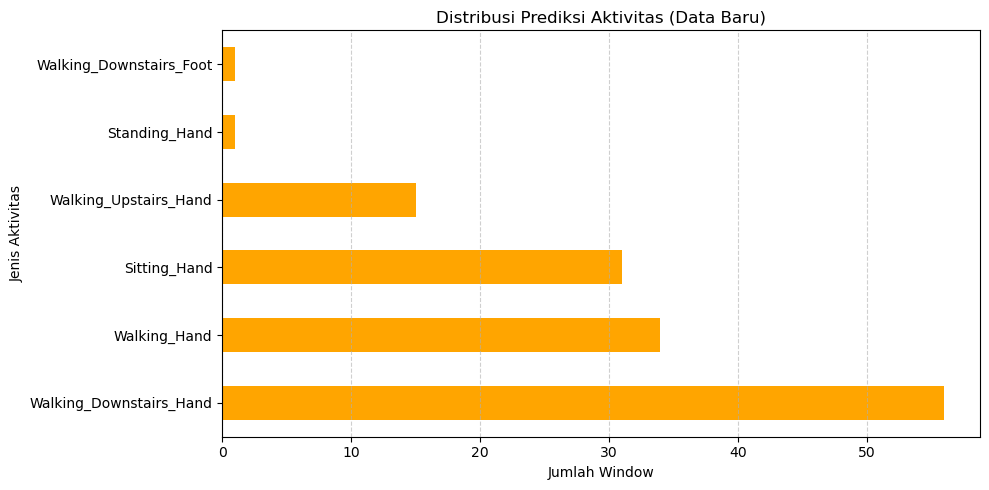

In [44]:
# =========================================================
# 1️⃣ Import library
# =========================================================
import pandas as pd
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt

# =========================================================
# 2️⃣ Path model dan folder data baru
# =========================================================
MODEL_PATH = r"C:\Users\Zain Iqbal Saputra\Pemrograman Sains Data 2\Time Series\Models\rf_model.pkl"
NEW_FOLDER = r"C:\Users\Zain Iqbal Saputra\Pemrograman Sains Data 2\Time Series\New_Data\Data_Bagas"

# Contoh:
# NEW_FOLDER = r"C:\Users\Zain Iqbal Saputra\Pemrograman Sains Data 2\Time Series\New_Data\Jalan"

# =========================================================
# 3️⃣ Pastikan tiga file sensor ada
# =========================================================
accel_file = os.path.join(NEW_FOLDER, "Accelerometer.csv")
gyro_file = os.path.join(NEW_FOLDER, "Gyroscope.csv")
mag_file = os.path.join(NEW_FOLDER, "Magnetometer.csv")

if not (os.path.exists(accel_file) and os.path.exists(gyro_file) and os.path.exists(mag_file)):
    raise FileNotFoundError("❌ Pastikan ada Accelerometer.csv, Gyroscope.csv, dan Magnetometer.csv di folder ini!")

# =========================================================
# 4️⃣ Gabungkan tiga sensor jadi satu dataframe
# =========================================================
accel = pd.read_csv(accel_file)
gyro = pd.read_csv(gyro_file)
mag = pd.read_csv(mag_file)

# Samakan waktu (2 desimal)
accel["Time (s)"] = accel["Time (s)"].round(2)
gyro["Time (s)"] = gyro["Time (s)"].round(2)
mag["Time (s)"] = mag["Time (s)"].round(2)

accel.columns = ["Time (s)", "Accel_X", "Accel_Y", "Accel_Z"]
gyro.columns = ["Time (s)", "Gyro_X", "Gyro_Y", "Gyro_Z"]
mag.columns = ["Time (s)", "Mag_X", "Mag_Y", "Mag_Z"]

data_new = accel.merge(gyro, on="Time (s)").merge(mag, on="Time (s)")

print(f"✅ Data baru berhasil digabung! Jumlah baris: {len(data_new)}")
display(data_new.head())

# =========================================================
# 5️⃣ Fungsi ekstraksi fitur (harus sama kayak training)
# =========================================================
def extract_features_from_window(window_df):
    feats = {}
    cols = ["Accel_X","Accel_Y","Accel_Z","Gyro_X","Gyro_Y","Gyro_Z","Mag_X","Mag_Y","Mag_Z"]
    for col in cols:
        vals = window_df[col].values
        feats[f"{col}_mean"] = np.mean(vals)
        feats[f"{col}_std"] = np.std(vals)
        feats[f"{col}_max"] = np.max(vals)
        feats[f"{col}_min"] = np.min(vals)
        feats[f"{col}_range"] = np.max(vals) - np.min(vals)
        feats[f"{col}_energy"] = np.sum(vals**2) / len(vals)
    return feats

# =========================================================
# 6️⃣ Windowing dan ekstraksi fitur
# =========================================================
WINDOW_SIZE = 200
STEP_SIZE = 100
windows = []

for i in range(0, len(data_new) - WINDOW_SIZE, STEP_SIZE):
    window = data_new.iloc[i:i+WINDOW_SIZE]
    feat = extract_features_from_window(window)
    windows.append(feat)

features_df = pd.DataFrame(windows)
print(f"🔍 Total window diekstraksi: {len(features_df)}")

# =========================================================
# 7️⃣ Load model dan prediksi
# =========================================================
model = joblib.load(MODEL_PATH)
predictions = model.predict(features_df)

# =========================================================
# 8️⃣ Decode angka prediksi jadi nama aktivitas
# =========================================================
activity_labels = [
    "Laying_Foot","Laying_Hand","Sitting_Foot","Sitting_Hand",
    "Standing_Foot","Standing_Hand","Walking_Foot","Walking_Hand",
    "Walking_Downstairs_Foot","Walking_Downstairs_Hand",
    "Walking_Upstairs_Foot","Walking_Upstairs_Hand"
]
decoded_predictions = [activity_labels[i] for i in predictions]

hasil_final = pd.Series(decoded_predictions).value_counts().idxmax()
print("\n=== HASIL PREDIKSI UTAMA ===")
print("Aktivitas terdeteksi:", hasil_final)
print("==============================")

# =========================================================
# 9️⃣ Interpretasi hasil
# =========================================================
interpretasi = {
    "Laying_Foot": "Subjek berbaring (sensor di kaki).",
    "Laying_Hand": "Subjek berbaring (sensor di tangan).",
    "Sitting_Foot": "Subjek duduk (sensor di kaki).",
    "Sitting_Hand": "Subjek duduk (sensor di tangan).",
    "Standing_Foot": "Subjek berdiri (sensor di kaki).",
    "Standing_Hand": "Subjek berdiri (sensor di tangan).",
    "Walking_Foot": "Subjek berjalan (sensor di kaki).",
    "Walking_Hand": "Subjek berjalan (sensor di tangan).",
    "Walking_Downstairs_Foot": "Subjek menuruni tangga (sensor di kaki).",
    "Walking_Downstairs_Hand": "Subjek menuruni tangga (sensor di tangan).",
    "Walking_Upstairs_Foot": "Subjek menaiki tangga (sensor di kaki).",
    "Walking_Upstairs_Hand": "Subjek menaiki tangga (sensor di tangan)."
}

print("\n📖 Interpretasi hasil:")
print(interpretasi.get(hasil_final, "Aktivitas tidak dikenali."))

# =========================================================
# 🔟 Visualisasi hasil
# =========================================================
plt.figure(figsize=(10,5))
pd.Series(decoded_predictions).value_counts().plot(kind="barh", color="orange")
plt.title("Distribusi Prediksi Aktivitas (Data Baru)")
plt.xlabel("Jumlah Window")
plt.ylabel("Jenis Aktivitas")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Data bagas Lagi

✅ Data baru berhasil digabung! Jumlah baris: 9122


,Time (s),Accel_X,Accel_Y,Accel_Z,Gyro_X,Gyro_Y,Gyro_Z,Mag_X,Mag_Y,Mag_Z
0,0.05,-3.46500,1.84500,10.035001,-0.793787,-1.580425,0.072462,-89.4375,-12.4875,-2.04375
1,0.05,-3.46500,1.84500,10.035001,-0.772475,-1.558150,0.087312,-89.4375,-12.4875,-2.04375
2,0.05,-3.46500,1.84500,10.035001,-0.746900,-1.537938,0.106425,-89.4375,-12.4875,-2.04375
3,0.05,-3.46500,1.84500,10.035001,-0.721325,-1.519788,0.119213,-89.4375,-12.4875,-2.04375
4,0.05,-3.38895,1.77405,10.099951,-0.793787,-1.580425,0.072462,-89.4375,-12.4875,-2.04375


🔍 Total window diekstraksi: 90

=== HASIL PREDIKSI UTAMA ===
Aktivitas terdeteksi: Sitting_Hand

📖 Interpretasi hasil:
Subjek duduk (sensor di tangan).


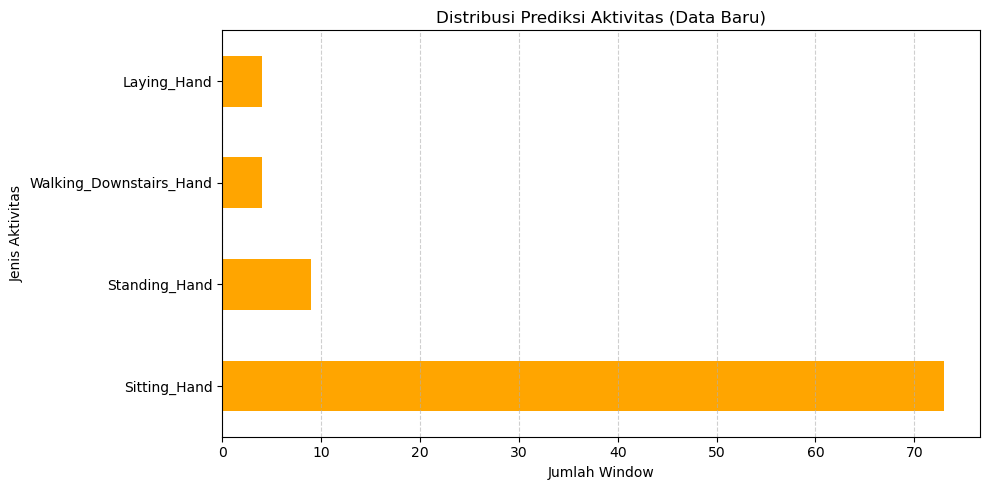

In [46]:
# =========================================================
# 1️⃣ Import library
# =========================================================
import pandas as pd
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt

# =========================================================
# 2️⃣ Path model dan folder data baru
# =========================================================
MODEL_PATH = r"C:\Users\Zain Iqbal Saputra\Pemrograman Sains Data 2\Time Series\Models\rf_model.pkl"
NEW_FOLDER = r"C:\Users\Zain Iqbal Saputra\Pemrograman Sains Data 2\Time Series\New_Data\Data_Bagas1"

# Contoh:
# NEW_FOLDER = r"C:\Users\Zain Iqbal Saputra\Pemrograman Sains Data 2\Time Series\New_Data\Jalan"

# =========================================================
# 3️⃣ Pastikan tiga file sensor ada
# =========================================================
accel_file = os.path.join(NEW_FOLDER, "Accelerometer.csv")
gyro_file = os.path.join(NEW_FOLDER, "Gyroscope.csv")
mag_file = os.path.join(NEW_FOLDER, "Magnetometer.csv")

if not (os.path.exists(accel_file) and os.path.exists(gyro_file) and os.path.exists(mag_file)):
    raise FileNotFoundError("❌ Pastikan ada Accelerometer.csv, Gyroscope.csv, dan Magnetometer.csv di folder ini!")

# =========================================================
# 4️⃣ Gabungkan tiga sensor jadi satu dataframe
# =========================================================
accel = pd.read_csv(accel_file)
gyro = pd.read_csv(gyro_file)
mag = pd.read_csv(mag_file)

# Samakan waktu (2 desimal)
accel["Time (s)"] = accel["Time (s)"].round(2)
gyro["Time (s)"] = gyro["Time (s)"].round(2)
mag["Time (s)"] = mag["Time (s)"].round(2)

accel.columns = ["Time (s)", "Accel_X", "Accel_Y", "Accel_Z"]
gyro.columns = ["Time (s)", "Gyro_X", "Gyro_Y", "Gyro_Z"]
mag.columns = ["Time (s)", "Mag_X", "Mag_Y", "Mag_Z"]

data_new = accel.merge(gyro, on="Time (s)").merge(mag, on="Time (s)")

print(f"✅ Data baru berhasil digabung! Jumlah baris: {len(data_new)}")
display(data_new.head())

# =========================================================
# 5️⃣ Fungsi ekstraksi fitur (harus sama kayak training)
# =========================================================
def extract_features_from_window(window_df):
    feats = {}
    cols = ["Accel_X","Accel_Y","Accel_Z","Gyro_X","Gyro_Y","Gyro_Z","Mag_X","Mag_Y","Mag_Z"]
    for col in cols:
        vals = window_df[col].values
        feats[f"{col}_mean"] = np.mean(vals)
        feats[f"{col}_std"] = np.std(vals)
        feats[f"{col}_max"] = np.max(vals)
        feats[f"{col}_min"] = np.min(vals)
        feats[f"{col}_range"] = np.max(vals) - np.min(vals)
        feats[f"{col}_energy"] = np.sum(vals**2) / len(vals)
    return feats

# =========================================================
# 6️⃣ Windowing dan ekstraksi fitur
# =========================================================
WINDOW_SIZE = 200
STEP_SIZE = 100
windows = []

for i in range(0, len(data_new) - WINDOW_SIZE, STEP_SIZE):
    window = data_new.iloc[i:i+WINDOW_SIZE]
    feat = extract_features_from_window(window)
    windows.append(feat)

features_df = pd.DataFrame(windows)
print(f"🔍 Total window diekstraksi: {len(features_df)}")

# =========================================================
# 7️⃣ Load model dan prediksi
# =========================================================
model = joblib.load(MODEL_PATH)
predictions = model.predict(features_df)

# =========================================================
# 8️⃣ Decode angka prediksi jadi nama aktivitas
# =========================================================
activity_labels = [
    "Laying_Foot","Laying_Hand","Sitting_Foot","Sitting_Hand",
    "Standing_Foot","Standing_Hand","Walking_Foot","Walking_Hand",
    "Walking_Downstairs_Foot","Walking_Downstairs_Hand",
    "Walking_Upstairs_Foot","Walking_Upstairs_Hand"
]
decoded_predictions = [activity_labels[i] for i in predictions]

hasil_final = pd.Series(decoded_predictions).value_counts().idxmax()
print("\n=== HASIL PREDIKSI UTAMA ===")
print("Aktivitas terdeteksi:", hasil_final)
print("==============================")

# =========================================================
# 9️⃣ Interpretasi hasil
# =========================================================
interpretasi = {
    "Laying_Foot": "Subjek berbaring (sensor di kaki).",
    "Laying_Hand": "Subjek berbaring (sensor di tangan).",
    "Sitting_Foot": "Subjek duduk (sensor di kaki).",
    "Sitting_Hand": "Subjek duduk (sensor di tangan).",
    "Standing_Foot": "Subjek berdiri (sensor di kaki).",
    "Standing_Hand": "Subjek berdiri (sensor di tangan).",
    "Walking_Foot": "Subjek berjalan (sensor di kaki).",
    "Walking_Hand": "Subjek berjalan (sensor di tangan).",
    "Walking_Downstairs_Foot": "Subjek menuruni tangga (sensor di kaki).",
    "Walking_Downstairs_Hand": "Subjek menuruni tangga (sensor di tangan).",
    "Walking_Upstairs_Foot": "Subjek menaiki tangga (sensor di kaki).",
    "Walking_Upstairs_Hand": "Subjek menaiki tangga (sensor di tangan)."
}

print("\n📖 Interpretasi hasil:")
print(interpretasi.get(hasil_final, "Aktivitas tidak dikenali."))

# =========================================================
# 🔟 Visualisasi hasil
# =========================================================
plt.figure(figsize=(10,5))
pd.Series(decoded_predictions).value_counts().plot(kind="barh", color="orange")
plt.title("Distribusi Prediksi Aktivitas (Data Baru)")
plt.xlabel("Jumlah Window")
plt.ylabel("Jenis Aktivitas")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Nyoba Rebahan jir

✅ Data baru berhasil digabung! Jumlah baris: 23649


,Time (s),Accel_X,Accel_Y,Accel_Z,Gyro_X,Gyro_Y,Gyro_Z,Mag_X,Mag_Y,Mag_Z
0,0.07,5.288736,2.529213,-5.808577,0.265783,-0.171108,-0.095741,-41.370197,87.681396,10.492
1,0.07,5.288736,2.529213,-5.808577,0.307329,-0.189217,-0.090414,-41.370197,87.681396,10.492
2,0.07,5.288736,2.529213,-5.808577,0.354200,-0.198805,-0.086153,-41.370197,87.681396,10.492
3,0.07,5.087739,2.443072,-5.746364,0.265783,-0.171108,-0.095741,-41.370197,87.681396,10.492
4,0.07,5.087739,2.443072,-5.746364,0.307329,-0.189217,-0.090414,-41.370197,87.681396,10.492


🔍 Total window diekstraksi: 235

=== HASIL PREDIKSI UTAMA ===
Aktivitas terdeteksi: Sitting_Foot

📖 Interpretasi hasil:
Subjek duduk (sensor di kaki).


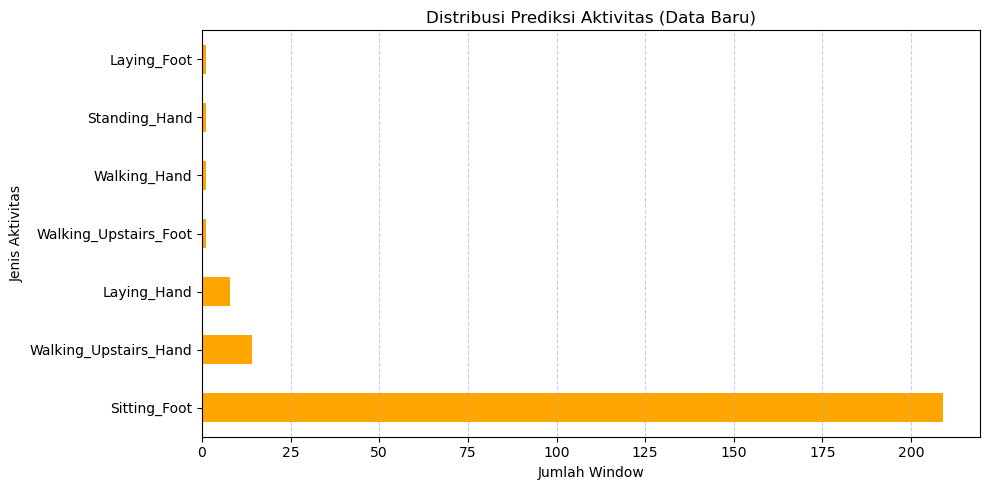

In [48]:
# =========================================================
# 1️⃣ Import library
# =========================================================
import pandas as pd
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt

# =========================================================
# 2️⃣ Path model dan folder data baru
# =========================================================
MODEL_PATH = r"C:\Users\Zain Iqbal Saputra\Pemrograman Sains Data 2\Time Series\Models\rf_model.pkl"
NEW_FOLDER = r"C:\Users\Zain Iqbal Saputra\Pemrograman Sains Data 2\Time Series\New_Data\Data_Zain"

# Contoh:
# NEW_FOLDER = r"C:\Users\Zain Iqbal Saputra\Pemrograman Sains Data 2\Time Series\New_Data\Jalan"

# =========================================================
# 3️⃣ Pastikan tiga file sensor ada
# =========================================================
accel_file = os.path.join(NEW_FOLDER, "Accelerometer.csv")
gyro_file = os.path.join(NEW_FOLDER, "Gyroscope.csv")
mag_file = os.path.join(NEW_FOLDER, "Magnetometer.csv")

if not (os.path.exists(accel_file) and os.path.exists(gyro_file) and os.path.exists(mag_file)):
    raise FileNotFoundError("❌ Pastikan ada Accelerometer.csv, Gyroscope.csv, dan Magnetometer.csv di folder ini!")

# =========================================================
# 4️⃣ Gabungkan tiga sensor jadi satu dataframe
# =========================================================
accel = pd.read_csv(accel_file)
gyro = pd.read_csv(gyro_file)
mag = pd.read_csv(mag_file)

# Samakan waktu (2 desimal)
accel["Time (s)"] = accel["Time (s)"].round(2)
gyro["Time (s)"] = gyro["Time (s)"].round(2)
mag["Time (s)"] = mag["Time (s)"].round(2)

accel.columns = ["Time (s)", "Accel_X", "Accel_Y", "Accel_Z"]
gyro.columns = ["Time (s)", "Gyro_X", "Gyro_Y", "Gyro_Z"]
mag.columns = ["Time (s)", "Mag_X", "Mag_Y", "Mag_Z"]

data_new = accel.merge(gyro, on="Time (s)").merge(mag, on="Time (s)")

print(f"✅ Data baru berhasil digabung! Jumlah baris: {len(data_new)}")
display(data_new.head())

# =========================================================
# 5️⃣ Fungsi ekstraksi fitur (harus sama kayak training)
# =========================================================
def extract_features_from_window(window_df):
    feats = {}
    cols = ["Accel_X","Accel_Y","Accel_Z","Gyro_X","Gyro_Y","Gyro_Z","Mag_X","Mag_Y","Mag_Z"]
    for col in cols:
        vals = window_df[col].values
        feats[f"{col}_mean"] = np.mean(vals)
        feats[f"{col}_std"] = np.std(vals)
        feats[f"{col}_max"] = np.max(vals)
        feats[f"{col}_min"] = np.min(vals)
        feats[f"{col}_range"] = np.max(vals) - np.min(vals)
        feats[f"{col}_energy"] = np.sum(vals**2) / len(vals)
    return feats

# =========================================================
# 6️⃣ Windowing dan ekstraksi fitur
# =========================================================
WINDOW_SIZE = 200
STEP_SIZE = 100
windows = []

for i in range(0, len(data_new) - WINDOW_SIZE, STEP_SIZE):
    window = data_new.iloc[i:i+WINDOW_SIZE]
    feat = extract_features_from_window(window)
    windows.append(feat)

features_df = pd.DataFrame(windows)
print(f"🔍 Total window diekstraksi: {len(features_df)}")

# =========================================================
# 7️⃣ Load model dan prediksi
# =========================================================
model = joblib.load(MODEL_PATH)
predictions = model.predict(features_df)

# =========================================================
# 8️⃣ Decode angka prediksi jadi nama aktivitas
# =========================================================
activity_labels = [
    "Laying_Foot","Laying_Hand","Sitting_Foot","Sitting_Hand",
    "Standing_Foot","Standing_Hand","Walking_Foot","Walking_Hand",
    "Walking_Downstairs_Foot","Walking_Downstairs_Hand",
    "Walking_Upstairs_Foot","Walking_Upstairs_Hand"
]
decoded_predictions = [activity_labels[i] for i in predictions]

hasil_final = pd.Series(decoded_predictions).value_counts().idxmax()
print("\n=== HASIL PREDIKSI UTAMA ===")
print("Aktivitas terdeteksi:", hasil_final)
print("==============================")

# =========================================================
# 9️⃣ Interpretasi hasil
# =========================================================
interpretasi = {
    "Laying_Foot": "Subjek berbaring (sensor di kaki).",
    "Laying_Hand": "Subjek berbaring (sensor di tangan).",
    "Sitting_Foot": "Subjek duduk (sensor di kaki).",
    "Sitting_Hand": "Subjek duduk (sensor di tangan).",
    "Standing_Foot": "Subjek berdiri (sensor di kaki).",
    "Standing_Hand": "Subjek berdiri (sensor di tangan).",
    "Walking_Foot": "Subjek berjalan (sensor di kaki).",
    "Walking_Hand": "Subjek berjalan (sensor di tangan).",
    "Walking_Downstairs_Foot": "Subjek menuruni tangga (sensor di kaki).",
    "Walking_Downstairs_Hand": "Subjek menuruni tangga (sensor di tangan).",
    "Walking_Upstairs_Foot": "Subjek menaiki tangga (sensor di kaki).",
    "Walking_Upstairs_Hand": "Subjek menaiki tangga (sensor di tangan)."
}

print("\n📖 Interpretasi hasil:")
print(interpretasi.get(hasil_final, "Aktivitas tidak dikenali."))

# =========================================================
# 🔟 Visualisasi hasil
# =========================================================
plt.figure(figsize=(10,5))
pd.Series(decoded_predictions).value_counts().plot(kind="barh", color="orange")
plt.title("Distribusi Prediksi Aktivitas (Data Baru)")
plt.xlabel("Jumlah Window")
plt.ylabel("Jenis Aktivitas")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

✅ Data baru berhasil digabung! Jumlah baris: 21927


,Time (s),Accel_X,Accel_Y,Accel_Z,Gyro_X,Gyro_Y,Gyro_Z,Mag_X,Mag_Y,Mag_Z
0,0.06,-4.786243,-5.821737,7.326225,0.179630,0.125967,-0.229964,-14.6888,-41.7118,-15.189
1,0.06,-4.786243,-5.821737,7.326225,0.176434,0.144077,-0.208659,-14.6888,-41.7118,-15.189
2,0.06,-4.762315,-5.816952,7.326225,0.179630,0.125967,-0.229964,-14.6888,-41.7118,-15.189
3,0.06,-4.762315,-5.816952,7.326225,0.176434,0.144077,-0.208659,-14.6888,-41.7118,-15.189
4,0.06,-4.786243,-5.812166,7.292725,0.179630,0.125967,-0.229964,-14.6888,-41.7118,-15.189


🔍 Total window diekstraksi: 218

=== HASIL PREDIKSI UTAMA ===
Aktivitas terdeteksi: Walking_Upstairs_Hand

📖 Interpretasi hasil:
Subjek menaiki tangga (sensor di tangan).


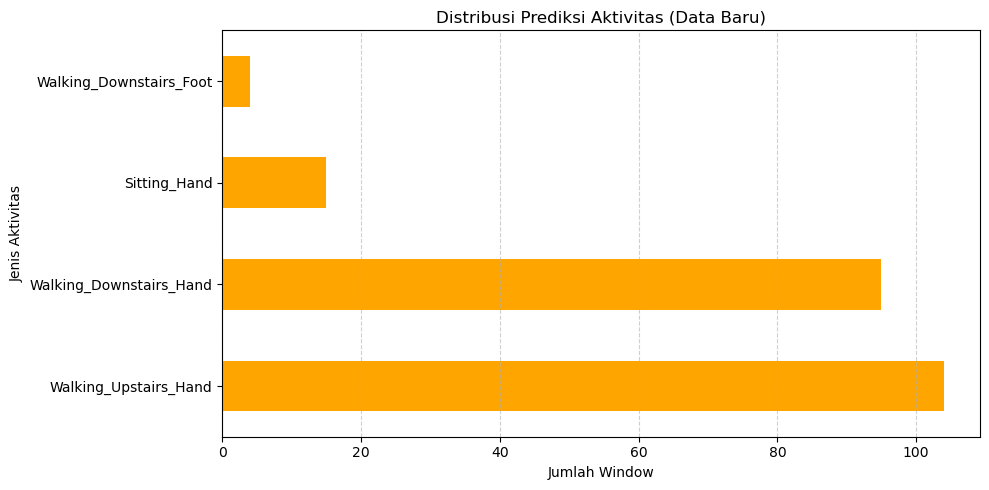

In [1]:
# =========================================================
# 1️⃣ Import library
# =========================================================
import pandas as pd
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt

# =========================================================
# 2️⃣ Path model dan folder data baru
# =========================================================
MODEL_PATH = r"C:\Users\Zain Iqbal Saputra\Pemrograman Sains Data 2\Time Series\Models\rf_model.pkl"
NEW_FOLDER = r"C:\Users\Zain Iqbal Saputra\Pemrograman Sains Data 2\Time Series\New_Data\Data_Syifa"

# Contoh:
# NEW_FOLDER = r"C:\Users\Zain Iqbal Saputra\Pemrograman Sains Data 2\Time Series\New_Data\Jalan"

# =========================================================
# 3️⃣ Pastikan tiga file sensor ada
# =========================================================
accel_file = os.path.join(NEW_FOLDER, "Accelerometer.csv")
gyro_file = os.path.join(NEW_FOLDER, "Gyroscope.csv")
mag_file = os.path.join(NEW_FOLDER, "Magnetometer.csv")

if not (os.path.exists(accel_file) and os.path.exists(gyro_file) and os.path.exists(mag_file)):
    raise FileNotFoundError("❌ Pastikan ada Accelerometer.csv, Gyroscope.csv, dan Magnetometer.csv di folder ini!")

# =========================================================
# 4️⃣ Gabungkan tiga sensor jadi satu dataframe
# =========================================================
accel = pd.read_csv(accel_file)
gyro = pd.read_csv(gyro_file)
mag = pd.read_csv(mag_file)

# Samakan waktu (2 desimal)
accel["Time (s)"] = accel["Time (s)"].round(2)
gyro["Time (s)"] = gyro["Time (s)"].round(2)
mag["Time (s)"] = mag["Time (s)"].round(2)

accel.columns = ["Time (s)", "Accel_X", "Accel_Y", "Accel_Z"]
gyro.columns = ["Time (s)", "Gyro_X", "Gyro_Y", "Gyro_Z"]
mag.columns = ["Time (s)", "Mag_X", "Mag_Y", "Mag_Z"]

data_new = accel.merge(gyro, on="Time (s)").merge(mag, on="Time (s)")

print(f"✅ Data baru berhasil digabung! Jumlah baris: {len(data_new)}")
display(data_new.head())

# =========================================================
# 5️⃣ Fungsi ekstraksi fitur (harus sama kayak training)
# =========================================================
def extract_features_from_window(window_df):
    feats = {}
    cols = ["Accel_X","Accel_Y","Accel_Z","Gyro_X","Gyro_Y","Gyro_Z","Mag_X","Mag_Y","Mag_Z"]
    for col in cols:
        vals = window_df[col].values
        feats[f"{col}_mean"] = np.mean(vals)
        feats[f"{col}_std"] = np.std(vals)
        feats[f"{col}_max"] = np.max(vals)
        feats[f"{col}_min"] = np.min(vals)
        feats[f"{col}_range"] = np.max(vals) - np.min(vals)
        feats[f"{col}_energy"] = np.sum(vals**2) / len(vals)
    return feats

# =========================================================
# 6️⃣ Windowing dan ekstraksi fitur
# =========================================================
WINDOW_SIZE = 200
STEP_SIZE = 100
windows = []

for i in range(0, len(data_new) - WINDOW_SIZE, STEP_SIZE):
    window = data_new.iloc[i:i+WINDOW_SIZE]
    feat = extract_features_from_window(window)
    windows.append(feat)

features_df = pd.DataFrame(windows)
print(f"🔍 Total window diekstraksi: {len(features_df)}")

# =========================================================
# 7️⃣ Load model dan prediksi
# =========================================================
model = joblib.load(MODEL_PATH)
predictions = model.predict(features_df)

# =========================================================
# 8️⃣ Decode angka prediksi jadi nama aktivitas
# =========================================================
activity_labels = [
    "Laying_Foot","Laying_Hand","Sitting_Foot","Sitting_Hand",
    "Standing_Foot","Standing_Hand","Walking_Foot","Walking_Hand",
    "Walking_Downstairs_Foot","Walking_Downstairs_Hand",
    "Walking_Upstairs_Foot","Walking_Upstairs_Hand"
]
decoded_predictions = [activity_labels[i] for i in predictions]

hasil_final = pd.Series(decoded_predictions).value_counts().idxmax()
print("\n=== HASIL PREDIKSI UTAMA ===")
print("Aktivitas terdeteksi:", hasil_final)
print("==============================")

# =========================================================
# 9️⃣ Interpretasi hasil
# =========================================================
interpretasi = {
    "Laying_Foot": "Subjek berbaring (sensor di kaki).",
    "Laying_Hand": "Subjek berbaring (sensor di tangan).",
    "Sitting_Foot": "Subjek duduk (sensor di kaki).",
    "Sitting_Hand": "Subjek duduk (sensor di tangan).",
    "Standing_Foot": "Subjek berdiri (sensor di kaki).",
    "Standing_Hand": "Subjek berdiri (sensor di tangan).",
    "Walking_Foot": "Subjek berjalan (sensor di kaki).",
    "Walking_Hand": "Subjek berjalan (sensor di tangan).",
    "Walking_Downstairs_Foot": "Subjek menuruni tangga (sensor di kaki).",
    "Walking_Downstairs_Hand": "Subjek menuruni tangga (sensor di tangan).",
    "Walking_Upstairs_Foot": "Subjek menaiki tangga (sensor di kaki).",
    "Walking_Upstairs_Hand": "Subjek menaiki tangga (sensor di tangan)."
}

print("\n📖 Interpretasi hasil:")
print(interpretasi.get(hasil_final, "Aktivitas tidak dikenali."))

# =========================================================
# 🔟 Visualisasi hasil
# =========================================================
plt.figure(figsize=(10,5))
pd.Series(decoded_predictions).value_counts().plot(kind="barh", color="orange")
plt.title("Distribusi Prediksi Aktivitas (Data Baru)")
plt.xlabel("Jumlah Window")
plt.ylabel("Jenis Aktivitas")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

✅ Data baru berhasil digabung! Jumlah baris: 31103


,Time (s),Accel_X,Accel_Y,Accel_Z,Gyro_X,Gyro_Y,Gyro_Z,Mag_X,Mag_Y,Mag_Z
0,0.08,-5.087739,-4.624130,7.737790,-0.166447,-0.062451,-0.017044,-7.2346,-43.0294,-6.9784
1,0.08,-5.087739,-4.624130,7.737790,-0.163252,-0.074169,-0.004261,-7.2346,-43.0294,-6.9784
2,0.08,-5.087739,-4.624130,7.737790,-0.158991,-0.082691,0.007457,-7.2346,-43.0294,-6.9784
3,0.08,-5.087739,-4.624130,7.737790,-0.157925,-0.094409,0.017044,-7.2346,-43.0294,-6.9784
4,0.08,-5.039883,-4.628915,7.752147,-0.166447,-0.062451,-0.017044,-7.2346,-43.0294,-6.9784


🔍 Total window diekstraksi: 310

=== HASIL PREDIKSI UTAMA ===
Aktivitas terdeteksi: Walking_Upstairs_Hand

📖 Interpretasi hasil:
Subjek menaiki tangga (sensor di tangan).


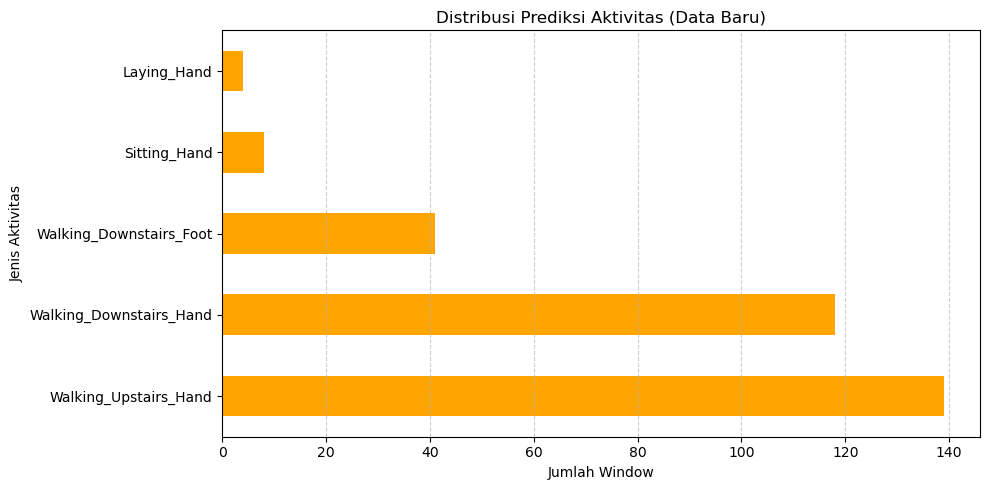

In [50]:
# Import library
import pandas as pd
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt

# Path model dan folder data baru
MODEL_PATH = r"C:\Users\Zain Iqbal Saputra\Pemrograman Sains Data 2\Time Series\Models\rf_model.pkl"
NEW_FOLDER = r"C:\Users\Zain Iqbal Saputra\Pemrograman Sains Data 2\Time Series\New_Data\Data_Syifa1"

# Pastikan tiga file sensor ada
accel_file = os.path.join(NEW_FOLDER, "Accelerometer.csv")
gyro_file = os.path.join(NEW_FOLDER, "Gyroscope.csv")
mag_file = os.path.join(NEW_FOLDER, "Magnetometer.csv")

if not (os.path.exists(accel_file) and os.path.exists(gyro_file) and os.path.exists(mag_file)):
    raise FileNotFoundError("❌ Pastikan ada Accelerometer.csv, Gyroscope.csv, dan Magnetometer.csv di folder ini!")

# Gabungkan tiga sensor jadi satu dataframe
accel = pd.read_csv(accel_file)
gyro = pd.read_csv(gyro_file)
mag = pd.read_csv(mag_file)

# Samakan waktu (2 desimal)
accel["Time (s)"] = accel["Time (s)"].round(2)
gyro["Time (s)"] = gyro["Time (s)"].round(2)
mag["Time (s)"] = mag["Time (s)"].round(2)

accel.columns = ["Time (s)", "Accel_X", "Accel_Y", "Accel_Z"]
gyro.columns = ["Time (s)", "Gyro_X", "Gyro_Y", "Gyro_Z"]
mag.columns = ["Time (s)", "Mag_X", "Mag_Y", "Mag_Z"]

data_new = accel.merge(gyro, on="Time (s)").merge(mag, on="Time (s)")

print(f"✅ Data baru berhasil digabung! Jumlah baris: {len(data_new)}")
display(data_new.head())

# Fungsi ekstraksi fitur (harus sama kayak training)
def extract_features_from_window(window_df):
    feats = {}
    cols = ["Accel_X","Accel_Y","Accel_Z","Gyro_X","Gyro_Y","Gyro_Z","Mag_X","Mag_Y","Mag_Z"]
    for col in cols:
        vals = window_df[col].values
        feats[f"{col}_mean"] = np.mean(vals)
        feats[f"{col}_std"] = np.std(vals)
        feats[f"{col}_max"] = np.max(vals)
        feats[f"{col}_min"] = np.min(vals)
        feats[f"{col}_range"] = np.max(vals) - np.min(vals)
        feats[f"{col}_energy"] = np.sum(vals**2) / len(vals)
    return feats

# Windowing dan ekstraksi fitur
WINDOW_SIZE = 200
STEP_SIZE = 100
windows = []

for i in range(0, len(data_new) - WINDOW_SIZE, STEP_SIZE):
    window = data_new.iloc[i:i+WINDOW_SIZE]
    feat = extract_features_from_window(window)
    windows.append(feat)

features_df = pd.DataFrame(windows)
print(f"🔍 Total window diekstraksi: {len(features_df)}")

# Load model dan prediksi
model = joblib.load(MODEL_PATH)
predictions = model.predict(features_df)

# Decode angka prediksi jadi nama aktivitas
activity_labels = [
    "Laying_Foot","Laying_Hand","Sitting_Foot","Sitting_Hand",
    "Standing_Foot","Standing_Hand","Walking_Foot","Walking_Hand",
    "Walking_Downstairs_Foot","Walking_Downstairs_Hand",
    "Walking_Upstairs_Foot","Walking_Upstairs_Hand"
]
decoded_predictions = [activity_labels[i] for i in predictions]

hasil_final = pd.Series(decoded_predictions).value_counts().idxmax()
print("\n=== HASIL PREDIKSI UTAMA ===")
print("Aktivitas terdeteksi:", hasil_final)
print("==============================")

# Interpretasi hasil
interpretasi = {
    "Laying_Foot": "Subjek berbaring (sensor di kaki).",
    "Laying_Hand": "Subjek berbaring (sensor di tangan).",
    "Sitting_Foot": "Subjek duduk (sensor di kaki).",
    "Sitting_Hand": "Subjek duduk (sensor di tangan).",
    "Standing_Foot": "Subjek berdiri (sensor di kaki).",
    "Standing_Hand": "Subjek berdiri (sensor di tangan).",
    "Walking_Foot": "Subjek berjalan (sensor di kaki).",
    "Walking_Hand": "Subjek berjalan (sensor di tangan).",
    "Walking_Downstairs_Foot": "Subjek menuruni tangga (sensor di kaki).",
    "Walking_Downstairs_Hand": "Subjek menuruni tangga (sensor di tangan).",
    "Walking_Upstairs_Foot": "Subjek menaiki tangga (sensor di kaki).",
    "Walking_Upstairs_Hand": "Subjek menaiki tangga (sensor di tangan)."
}

print("\n📖 Interpretasi hasil:")
print(interpretasi.get(hasil_final, "Aktivitas tidak dikenali."))

# Visualisasi hasil
plt.figure(figsize=(10,5))
pd.Series(decoded_predictions).value_counts().plot(kind="barh", color="orange")
plt.title("Distribusi Prediksi Aktivitas (Data Baru)")
plt.xlabel("Jumlah Window")
plt.ylabel("Jenis Aktivitas")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Real-Time

In [ ]:
import requests
import time

# Ganti alamat IP sesuai yang muncul di HP kamu
url = "http://172.30.42.185:8080/get?accX&accY&accZ"

print("Mulai membaca data sensor dari Phyphox...")
print("Pastikan Phyphox sedang dibuka dan remote access aktif!\n")

for i in range(200):  # ambil 50 kali data
    try:
        data = requests.get(url).json()
        ax = data["buffer"]["accX"]["buffer"][-1]
        ay = data["buffer"]["accY"]["buffer"][-1]
        az = data["buffer"]["accZ"]["buffer"][-1]
        print(f"{i+1:02d}. Accel_X={ax:.3f}, Accel_Y={ay:.3f}, Accel_Z={az:.3f}")
    except Exception as e:
        print("⚠️ Gagal ambil data:", e)
    time.sleep(0.2)

# Demo

✅ Data baru berhasil digabung! Jumlah baris: 31103


,Time (s),Accel_X,Accel_Y,Accel_Z,Gyro_X,Gyro_Y,Gyro_Z,Mag_X,Mag_Y,Mag_Z
0,0.08,-5.087739,-4.624130,7.737790,-0.166447,-0.062451,-0.017044,-7.2346,-43.0294,-6.9784
1,0.08,-5.087739,-4.624130,7.737790,-0.163252,-0.074169,-0.004261,-7.2346,-43.0294,-6.9784
2,0.08,-5.087739,-4.624130,7.737790,-0.158991,-0.082691,0.007457,-7.2346,-43.0294,-6.9784
3,0.08,-5.087739,-4.624130,7.737790,-0.157925,-0.094409,0.017044,-7.2346,-43.0294,-6.9784
4,0.08,-5.039883,-4.628915,7.752147,-0.166447,-0.062451,-0.017044,-7.2346,-43.0294,-6.9784


🔍 Total window diekstraksi: 310

=== HASIL PREDIKSI UTAMA ===
Aktivitas terdeteksi: Walking_Upstairs_Hand

📖 Interpretasi hasil:
Subjek menaiki tangga (sensor di tangan).


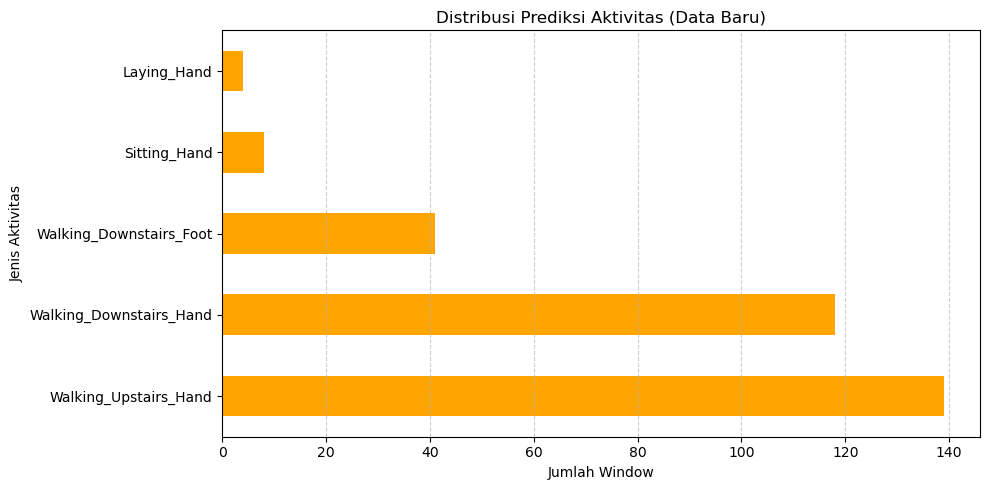

In [52]:
# Import library
import pandas as pd
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt

# Path model dan folder data baru
MODEL_PATH = r"C:\Users\Zain Iqbal Saputra\Pemrograman Sains Data 2\Time Series\Models\rf_model.pkl"
NEW_FOLDER = r"C:\Users\Zain Iqbal Saputra\Pemrograman Sains Data 2\Time Series\New_Data\Data_Syifa1"

# Pastikan tiga file sensor ada
accel_file = os.path.join(NEW_FOLDER, "Accelerometer.csv")
gyro_file = os.path.join(NEW_FOLDER, "Gyroscope.csv")
mag_file = os.path.join(NEW_FOLDER, "Magnetometer.csv")

if not (os.path.exists(accel_file) and os.path.exists(gyro_file) and os.path.exists(mag_file)):
    raise FileNotFoundError("❌ Pastikan ada Accelerometer.csv, Gyroscope.csv, dan Magnetometer.csv di folder ini!")

# Gabungkan tiga sensor jadi satu dataframe
accel = pd.read_csv(accel_file)
gyro = pd.read_csv(gyro_file)
mag = pd.read_csv(mag_file)

# Samakan waktu (2 desimal)
accel["Time (s)"] = accel["Time (s)"].round(2)
gyro["Time (s)"] = gyro["Time (s)"].round(2)
mag["Time (s)"] = mag["Time (s)"].round(2)

accel.columns = ["Time (s)", "Accel_X", "Accel_Y", "Accel_Z"]
gyro.columns = ["Time (s)", "Gyro_X", "Gyro_Y", "Gyro_Z"]
mag.columns = ["Time (s)", "Mag_X", "Mag_Y", "Mag_Z"]

data_new = accel.merge(gyro, on="Time (s)").merge(mag, on="Time (s)")

print(f"✅ Data baru berhasil digabung! Jumlah baris: {len(data_new)}")
display(data_new.head())

# Fungsi ekstraksi fitur (harus sama kayak training)
def extract_features_from_window(window_df):
    feats = {}
    cols = ["Accel_X","Accel_Y","Accel_Z","Gyro_X","Gyro_Y","Gyro_Z","Mag_X","Mag_Y","Mag_Z"]
    for col in cols:
        vals = window_df[col].values
        feats[f"{col}_mean"] = np.mean(vals)
        feats[f"{col}_std"] = np.std(vals)
        feats[f"{col}_max"] = np.max(vals)
        feats[f"{col}_min"] = np.min(vals)
        feats[f"{col}_range"] = np.max(vals) - np.min(vals)
        feats[f"{col}_energy"] = np.sum(vals**2) / len(vals)
    return feats

# Windowing dan ekstraksi fitur
WINDOW_SIZE = 200
STEP_SIZE = 100
windows = []

for i in range(0, len(data_new) - WINDOW_SIZE, STEP_SIZE):
    window = data_new.iloc[i:i+WINDOW_SIZE]
    feat = extract_features_from_window(window)
    windows.append(feat)

features_df = pd.DataFrame(windows)
print(f"🔍 Total window diekstraksi: {len(features_df)}")

# Load model dan prediksi
model = joblib.load(MODEL_PATH)
predictions = model.predict(features_df)

# Decode angka prediksi jadi nama aktivitas
activity_labels = [
    "Laying_Foot","Laying_Hand","Sitting_Foot","Sitting_Hand",
    "Standing_Foot","Standing_Hand","Walking_Foot","Walking_Hand",
    "Walking_Downstairs_Foot","Walking_Downstairs_Hand",
    "Walking_Upstairs_Foot","Walking_Upstairs_Hand"
]
decoded_predictions = [activity_labels[i] for i in predictions]

hasil_final = pd.Series(decoded_predictions).value_counts().idxmax()
print("\n=== HASIL PREDIKSI UTAMA ===")
print("Aktivitas terdeteksi:", hasil_final)
print("==============================")

# Interpretasi hasil
interpretasi = {
    "Laying_Foot": "Subjek berbaring (sensor di kaki).",
    "Laying_Hand": "Subjek berbaring (sensor di tangan).",
    "Sitting_Foot": "Subjek duduk (sensor di kaki).",
    "Sitting_Hand": "Subjek duduk (sensor di tangan).",
    "Standing_Foot": "Subjek berdiri (sensor di kaki).",
    "Standing_Hand": "Subjek berdiri (sensor di tangan).",
    "Walking_Foot": "Subjek berjalan (sensor di kaki).",
    "Walking_Hand": "Subjek berjalan (sensor di tangan).",
    "Walking_Downstairs_Foot": "Subjek menuruni tangga (sensor di kaki).",
    "Walking_Downstairs_Hand": "Subjek menuruni tangga (sensor di tangan).",
    "Walking_Upstairs_Foot": "Subjek menaiki tangga (sensor di kaki).",
    "Walking_Upstairs_Hand": "Subjek menaiki tangga (sensor di tangan)."
}

print("\n📖 Interpretasi hasil:")
print(interpretasi.get(hasil_final, "Aktivitas tidak dikenali."))

# Visualisasi hasil
plt.figure(figsize=(10,5))
pd.Series(decoded_predictions).value_counts().plot(kind="barh", color="orange")
plt.title("Distribusi Prediksi Aktivitas (Data Baru)")
plt.xlabel("Jumlah Window")
plt.ylabel("Jenis Aktivitas")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Ekspor Data

In [54]:
counts_df = pd.DataFrame({
    "Activity": list(counts.keys()),
    "RowCount": list(counts.values())
})
counts_df.to_csv("jumlah_data_per_aktivitas.csv", index=False)

In [58]:
FEATURES_CSV = r"..\Features\features_df.csv"   # ganti path kalau beda
LE_FILE = r"C:\Users\Zain Iqbal Saputra\Pemrograman Sains Data 2\Time Series\Models\label_encoder.pkl"

if os.path.exists(FEATURES_CSV):
    y = pd.read_csv(FEATURES_CSV)["Activity"].astype(str)
    le = LabelEncoder()
    le.fit(y)
    joblib.dump(le, LE_FILE)
    print("✅ LabelEncoder dibuat dari features_df.csv dan disimpan ke:", LE_FILE)
else:
    print("⚠️ features_df.csv tidak ditemukan di path:", FEATURES_CSV)

✅ LabelEncoder dibuat dari features_df.csv dan disimpan ke: C:\Users\Zain Iqbal Saputra\Pemrograman Sains Data 2\Time Series\Models\label_encoder.pkl


🔍 Membaca dan menggabungkan sensor...
Jumlah baris: 19285
Total window: 191
📁 Load model...
🔮 Prediksi...

🔰 HASIL PREDIKSI UTAMA 🔰
Aktivitas terdeteksi: Walking_Downstairs_Hand



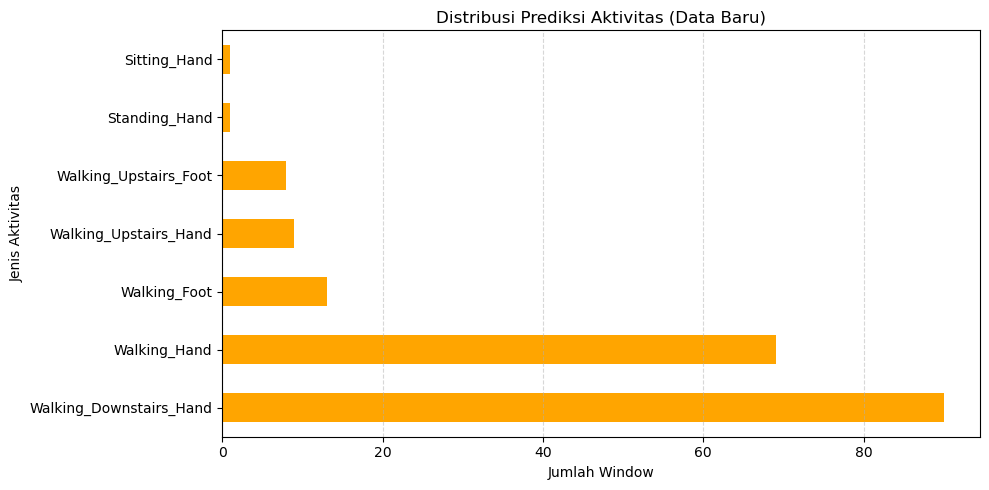

📁 File prediksi tersimpan: prediksi_data_baru.csv


In [60]:
# ----------------------------
# 1. LOAD FUNCTION MERGE SENSOR
# ----------------------------
def load_and_merge_sensor(folder_path):
    acc = pd.read_csv(os.path.join(folder_path, "Accelerometer.csv"))
    gyro = pd.read_csv(os.path.join(folder_path, "Gyroscope.csv"))
    mag = pd.read_csv(os.path.join(folder_path, "Magnetometer.csv"))

    acc["Time (s)"] = acc["Time (s)"].round(2)
    gyro["Time (s)"] = gyro["Time (s)"].round(2)
    mag["Time (s)"] = mag["Time (s)"].round(2)

    acc.columns = ["Time (s)", "Accel_X", "Accel_Y", "Accel_Z"]
    gyro.columns = ["Time (s)", "Gyro_X", "Gyro_Y", "Gyro_Z"]
    mag.columns = ["Time (s)", "Mag_X", "Mag_Y", "Mag_Z"]

    df = acc.merge(gyro, on="Time (s)").merge(mag, on="Time (s)")
    return df


# --------------------------------------------------
# 2. LOAD FUNCTION EKSTRAK FITUR (HARUS ADA!)
# --------------------------------------------------
def extract_features_from_window(window_df):
    feats = {}
    cols = ["Accel_X","Accel_Y","Accel_Z",
            "Gyro_X","Gyro_Y","Gyro_Z",
            "Mag_X","Mag_Y","Mag_Z"]

    for col in cols:
        vals = window_df[col].values
        feats[f"{col}_mean"]   = np.mean(vals)
        feats[f"{col}_std"]    = np.std(vals)
        feats[f"{col}_max"]    = np.max(vals)
        feats[f"{col}_min"]    = np.min(vals)
        feats[f"{col}_range"]  = np.max(vals) - np.min(vals)
        feats[f"{col}_energy"] = np.sum(vals**2) / len(vals)

    return feats


# -------------------------------------
# 3. PATH MODEL DAN LABEL ENCODER
# -------------------------------------
MODEL_FILE = r"C:\Users\Zain Iqbal Saputra\Pemrograman Sains Data 2\Time Series\Models\rf_model.pkl"
LE_FILE    = r"C:\Users\Zain Iqbal Saputra\Pemrograman Sains Data 2\Time Series\Models\label_encoder.pkl"

# Jika encoder disimpan di model training:
try:
    le = joblib.load(LE_FILE)
except:
    # kalau tidak ada file encoder — ambil dari model
    try:
        le = joblib.load(MODEL_FILE.replace("rf_model.pkl", "label_encoder.pkl"))
    except:
        raise Exception("❌ Label Encoder tidak ditemukan! Pastikan disimpan saat training.")


# -------------------------------------
# 4. CONFIG DATA BARU
# -------------------------------------
NEW_FOLDER = r"C:\Users\Zain Iqbal Saputra\Pemrograman Sains Data 2\Time Series\New_Data\New"

WINDOW_SIZE = 200
STEP_SIZE = 100

print("🔍 Membaca dan menggabungkan sensor...")
new_df = load_and_merge_sensor(NEW_FOLDER)
print("Jumlah baris:", len(new_df))


# -------------------------------------
# 5. WINDOWING
# -------------------------------------
windows = []
for i in range(0, len(new_df) - WINDOW_SIZE, STEP_SIZE):
    windows.append(new_df.iloc[i:i+WINDOW_SIZE])

print("Total window:", len(windows))

# -------------------------------------
# 6. FEATURE EXTRACTION
# -------------------------------------
features_new = pd.DataFrame([extract_features_from_window(w) for w in windows])


# -------------------------------------
# 7. LOAD MODEL & PREDICT
# -------------------------------------
print("📁 Load model...")
rf_model = joblib.load(MODEL_FILE)

print("🔮 Prediksi...")
predicted_labels = rf_model.predict(features_new)
decoded_predictions = le.inverse_transform(predicted_labels)

# -------------------------------------
# 8. HASIL PREDIKSI
# -------------------------------------
hasil_utama = pd.Series(decoded_predictions).value_counts().idxmax()

print("\n==============================")
print("🔰 HASIL PREDIKSI UTAMA 🔰")
print("Aktivitas terdeteksi:", hasil_utama)
print("==============================\n")

# -------------------------------------
# 9. VISUALISASI
# -------------------------------------
plt.figure(figsize=(10,5))
pd.Series(decoded_predictions).value_counts().plot(kind="barh", color="orange")
plt.title("Distribusi Prediksi Aktivitas (Data Baru)")
plt.xlabel("Jumlah Window")
plt.ylabel("Jenis Aktivitas")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# -------------------------------------
# 10. SAVE KE CSV
# -------------------------------------
pred_df = pd.DataFrame({
    "Window": range(len(decoded_predictions)),
    "Predicted_Activity": decoded_predictions
})
pred_df.to_csv("prediksi_data_baru.csv", index=False)

print("📁 File prediksi tersimpan: prediksi_data_baru.csv")

In [18]:
def load_and_merge_sensor(folder_path):
    import os
    import pandas as pd

    # Baca file sensor
    acc = pd.read_csv(os.path.join(folder_path, "Accelerometer.csv"))
    gyro = pd.read_csv(os.path.join(folder_path, "Gyroscope.csv"))
    mag = pd.read_csv(os.path.join(folder_path, "Magnetometer.csv"))

    # Samakan presisi waktu
    acc["Time (s)"] = acc["Time (s)"].round(2)
    gyro["Time (s)"] = gyro["Time (s)"].round(2)
    mag["Time (s)"] = mag["Time (s)"].round(2)

    # Rename kolom supaya rapi & sesuai training
    acc.columns = ["Time (s)", "Accel_X", "Accel_Y", "Accel_Z"]
    gyro.columns = ["Time (s)", "Gyro_X", "Gyro_Y", "Gyro_Z"]
    mag.columns = ["Time (s)", "Mag_X", "Mag_Y", "Mag_Z"]

    # Merge berdasarkan waktu
    df = acc.merge(gyro, on="Time (s)").merge(mag, on="Time (s)")
    return df

In [20]:
# === CONFIG ===
NEW_FOLDER = r"C:\Users\Zain Iqbal Saputra\Pemrograman Sains Data 2\Time Series\New_Data\New"
WINDOW_SIZE = 200
STEP_SIZE = 100

# === LOAD NEW SENSOR DATA ===
print("🔍 Membaca dan menggabungkan data sensor...")
new_df = load_and_merge_sensor(NEW_FOLDER)
print("Jumlah baris data baru:", len(new_df))

# WINDOWING
windows = []
for i in range(0, len(new_df) - WINDOW_SIZE, STEP_SIZE):
    windows.append(new_df.iloc[i:i+WINDOW_SIZE])

print("Total window:", len(windows))

# FEATURE EXTRACTION
features_new = [extract_features_from_window(w) for w in windows]
features_new = pd.DataFrame(features_new)

# LOAD MODEL + LABEL ENCODER
rf_model = joblib.load(MODEL_FILE)
predicted_labels = rf_model.predict(features_new)
decoded_predictions = le.inverse_transform(predicted_labels)

# HASIL UTAMA
hasil_utama = pd.Series(decoded_predictions).value_counts().idxmax()
print("\n=== HASIL PREDIKSI UTAMA ===")
print("Aktivitas terdeteksi:", hasil_utama)

# VISUALISASI
plt.figure(figsize=(10,5))
pd.Series(decoded_predictions).value_counts().plot(kind="barh", color="orange")
plt.title("Distribusi Prediksi Aktivitas (Data Baru)")
plt.xlabel("Jumlah Window")
plt.ylabel("Jenis Aktivitas")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

# SIMPAN CSV
pred_df = pd.DataFrame({
    "Window": range(len(decoded_predictions)),
    "Predicted_Activity": decoded_predictions
})
pred_df.to_csv("prediksi_data_baru.csv", index=False)
print("📁 Saved as prediksi_data_baru.csv")

🔍 Membaca dan menggabungkan data sensor...
Jumlah baris data baru: 19285
Total window: 191


NameError: name 'MODEL_FILE' is not defined

In [4]:
pred_df = pd.DataFrame({
    "Window": list(range(len(predicted_labels))),
    "Predicted": predicted_labels
})
pred_df.to_csv("prediksi_data_baru.csv", index=False)

NameError: name 'predicted_labels' is not defined